## XGBoost

In [1]:
import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

sys.path.append(os.path.abspath(os.path.join("..")))
from utils import calc_metrics

c:\Users\user\miniconda3\envs\ml_yp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

Предобработаем тексты пресс-релизов.

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words("russian"))
def preprocessor(text):
    text = text.lower()
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)
    text = " ".join(mystem.lemmatize(text))
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)
tf_idf = vectorizer.fit_transform(X.release)

Предобработаем таргет для XGBoost, нужно чтобы значения были 0, 1, 2

In [4]:
le = LabelEncoder()
y_le = le.fit_transform(y)

Сначала попробуем подобрать гиперпараметры вручную с помощью валидационной выборки, посмотрим на графики ошибки

100%|██████████| 5/5 [01:49<00:00, 21.96s/it]


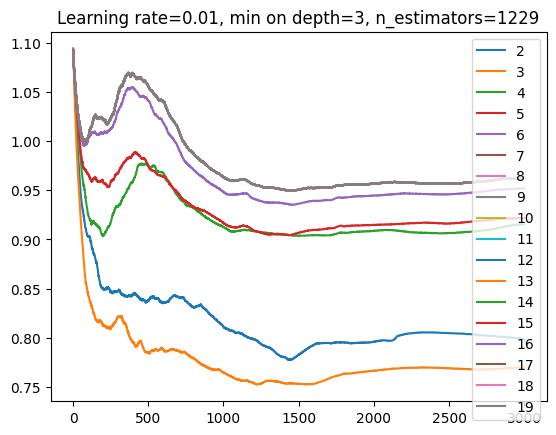

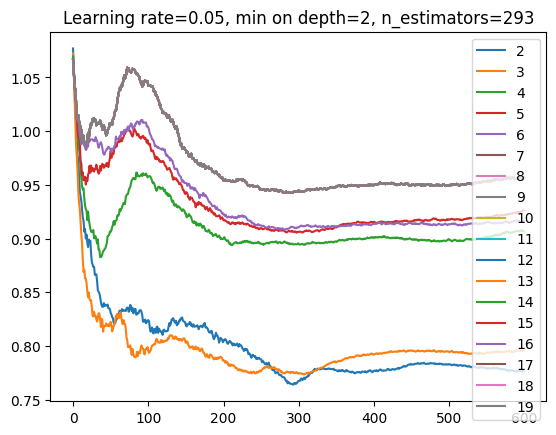

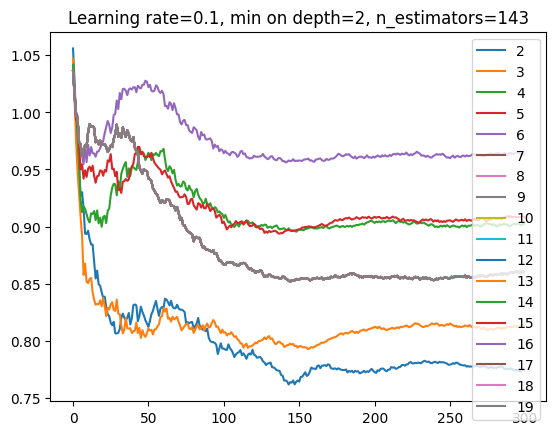

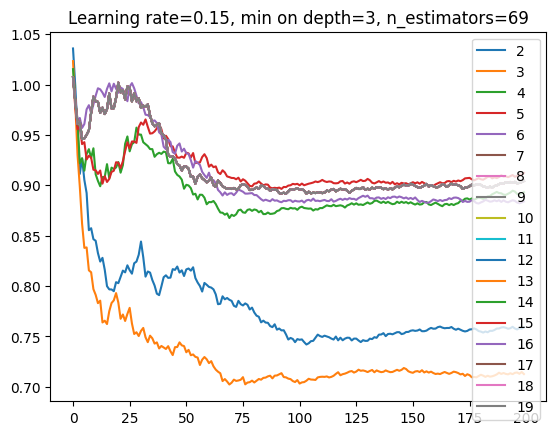

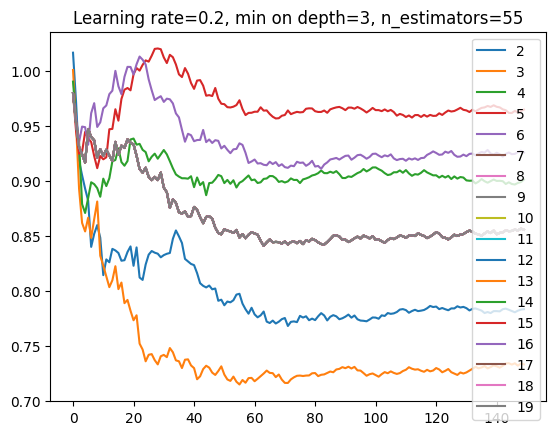

In [5]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y_le, test_size=0.1, random_state=42)
best_params = []
for lr in tqdm([0.01, 0.05, 0.1, 0.15, 0.2]):
    res = []
    for depth in range(2, 20):
        model = XGBClassifier(
            max_depth=depth,
            learning_rate=lr,
            n_estimators=int(30 / lr),
            random_state=42
        )
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        res.append(model.evals_result_['validation_0']['mlogloss'])
    res_arr = np.array(res)
    ij_min = np.unravel_index(res_arr.argmin(), res_arr.shape)
    best_params.append({'lr': lr, 'depth': ij_min[0] + 2, 'n_estimators': ij_min[1], 'mlogloss': res_arr[ij_min[0], ij_min[1]]})
    pd.DataFrame(res_arr.T, columns=range(2, 20)).plot(
        title=f"Learning rate={lr}, min on depth={ij_min[0] + 2}, n_estimators={ij_min[1]}"
        )


In [6]:
df_best_params = pd.DataFrame(best_params)
df_best_params

,lr,depth,n_estimators,mlogloss
0,0.01,3,1229,0.752386
1,0.05,2,293,0.764128
2,0.10,2,143,0.761761
3,0.15,3,69,0.702227
4,0.20,3,55,0.714797


              precision    recall  f1-score   support

           0       0.67      0.70      0.68        23
           1       0.50      0.57      0.53        28
           2       0.64      0.47      0.55        19

    accuracy                           0.59        70
   macro avg       0.60      0.58      0.59        70
weighted avg       0.59      0.59      0.59        70



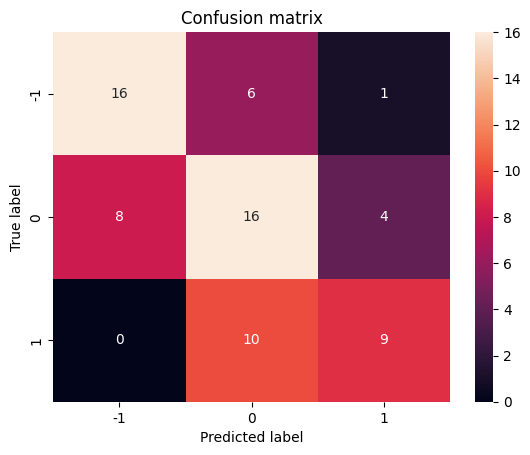

In [7]:
min_best_param = df_best_params[df_best_params['mlogloss'] == df_best_params['mlogloss'].min()]
model = XGBClassifier(
    max_depth=min_best_param['depth'].values[0],
    learning_rate=min_best_param['lr'].values[0],
    n_estimators=min_best_param['n_estimators'].values[0],
    random_state=42
)
metric, model = calc_metrics(
    tf_idf,
    y_le,
    model,
    name="TF-IDF XGBoost"
)

In [8]:
metric

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF XGBoost,0.585714,0.586546,0.580255,0.603175,0.75574,0.763035


In [9]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    }
    model = XGBClassifier(
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        random_state=42,
        n_jobs=-1,
    )
    metric, _ = calc_metrics(tf_idf, y_le, model, name=" ", plot=False)
    return metric


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 77. Best value: 0.78032: 100%|██████████| 100/100 [24:15<00:00, 14.55s/it]


In [10]:
study.best_params

{'max_depth': 19, 'n_estimators': 46, 'learning_rate': 0.11420518294904991}

Обучим модель с лучшими гиперпараметрами и посмотрим на качество.

In [11]:
model = XGBClassifier(
    max_depth=study.best_params["max_depth"],
    learning_rate=study.best_params["learning_rate"],
    n_estimators=study.best_params["n_estimators"],
    random_state=42,
)

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        23
           1       0.56      0.64      0.60        28
           2       0.71      0.53      0.61        19

    accuracy                           0.63        70
   macro avg       0.65      0.62      0.63        70
weighted avg       0.64      0.63      0.63        70



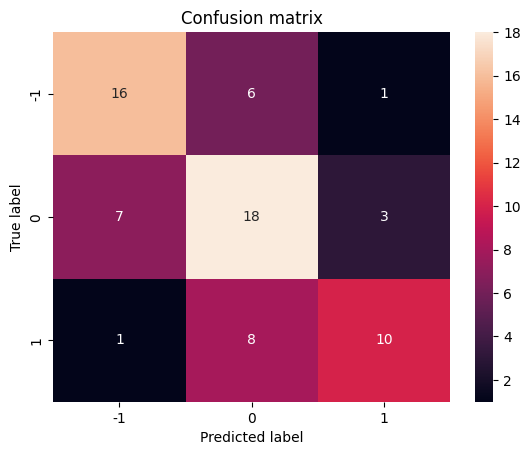

In [12]:
# вычисляем метрики
metric, model = calc_metrics(
    tf_idf,
    y_le,
    model,
    name="TF-IDF XGBoost"
)

In [13]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.742857,0.745614,0.749755,0.743050,0.840990,0.844114
K-neighbors tf_idf pca,0.728571,0.734787,0.727035,0.751111,0.816386,0.821299
K-neighbors word2vec,0.657143,0.637422,0.641441,0.745632,0.787306,0.789760
K-neighbors weighted word2vec,0.657143,0.637422,0.641441,0.745632,0.795419,0.797633
TF-IDF SelectFromModel Random Forest,0.642857,0.642165,0.627874,0.695332,0.798339,0.805117
TF-IDF PCA Random Forest,0.642857,0.640412,0.630462,0.685668,0.818108,0.823213
Word2Vec Random Forest,0.571429,0.571970,0.560586,0.603785,0.730344,0.735650
TF-IDF LigthGBM,0.514286,0.518519,0.510842,0.540305,0.711242,0.719380
TF-IDF XGBoost,0.628571,0.628971,0.621608,0.647817,0.774376,0.780320


In [14]:
metrics.to_csv('metrics.csv')

Optuna помогла нам подобрать параметры лучше. Но тем не менее, побить лучшую линейную модель не удалось.